In [9]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../flood_prediction') # going to the parent folder of the current folder
from data_prep import get_data_and_targets

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf

# Getting data from API (data_prep.py)

In [2]:
df = get_data_and_targets()

In [5]:
df.shape

(347685, 10)

In [6]:
df.head(5)

,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s),target
date,,,,,,,,,,
1984-01-01 00:00:00,19.2,0.0,982.1,4.5,331.0,0.251,0.278,0.0,48.77,0
1984-01-01 01:00:00,19.1,0.0,981.9,4.5,331.0,0.251,0.278,0.0,48.77,0
1984-01-01 02:00:00,18.6,0.0,982.0,4.1,345.0,0.251,0.278,0.0,48.77,0
1984-01-01 03:00:00,18.2,0.0,981.9,3.6,6.0,0.251,0.278,0.0,48.77,0
1984-01-01 04:00:00,17.7,0.0,981.9,3.7,11.0,0.251,0.278,0.0,48.77,0


In [7]:
df.drop(columns='target', inplace=True)
df.shape

(347685, 9)

# Defining goblal variables of the data set

In [13]:
TARGET = 'river_discharge(m3/s)'
N_TARGETS = 1
N_FEATURES = 8

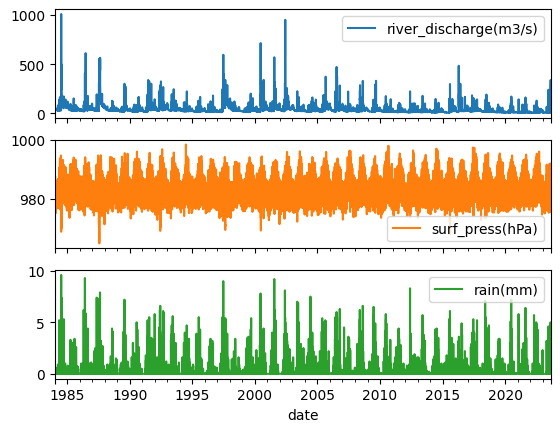

In [14]:
plot_cols = [TARGET, 'surf_press(hPa)', 'rain(mm)']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

In [16]:
DATA = dict(
    length = 347685, # How many timesteps does your dataset contains?
    n_covariates = 8, # number of past covariates, excluding target time series. Our tests do not support future_covariate yet.
    target_column_idx = [0] # List of index(es) of target column(s) in your dataset. e.g [0] for Mono-target problem, e.g. [0,1,4] for multi-variate targets problem. Note that past targets values will also be used as features X.
)

# Creating Folds

### Defining global variables

In [17]:
# Considering folds of 1 year
FOLD_LENGTH = 24 * 365

# Folds starting every trimester
FOLD_STRIDE = 24 * 91  # 1 quarter = 91 days

# train-test-split ratio of 2/3 
TRAIN_TEST_RATIO = 0.66

### Function to get folds

In [19]:

def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    """    
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    # $CHALLENGIFY_BEGIN
    
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [21]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 156 folds.
Each fold has a shape equal to (8760, 9).


In [24]:
fold = folds[0]
fold

,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s)
date,,,,,,,,,
1984-01-01 00:00:00,19.2,0.0,982.1,4.5,331.0,0.251,0.278,0.0,48.77
1984-01-01 01:00:00,19.1,0.0,981.9,4.5,331.0,0.251,0.278,0.0,48.77
1984-01-01 02:00:00,18.6,0.0,982.0,4.1,345.0,0.251,0.278,0.0,48.77
1984-01-01 03:00:00,18.2,0.0,981.9,3.6,6.0,0.251,0.278,0.0,48.77
1984-01-01 04:00:00,17.7,0.0,981.9,3.7,11.0,0.251,0.278,0.0,48.77
...,...,...,...,...,...,...,...,...,...
1984-12-30 19:00:00,24.9,0.0,980.7,13.8,242.0,0.258,0.279,460.0,85.30
1984-12-30 20:00:00,23.3,0.0,980.6,10.8,244.0,0.258,0.279,247.0,85.30
1984-12-30 21:00:00,21.5,0.0,980.8,5.7,252.0,0.258,0.279,55.0,85.30


# Train/Test split in the fold

### Defining global variables